# Analyse GPT2 model for selfchat

This notebook is meant for analysis and visualization of the results of evaluating the GPT2 model for dialogue generation.

The first part of the notebook lists available files in the folder with evaluation results. Use an appropriate filter to load the desired file(s) to analyze.
The analysis uses two types of files as input:
- files ending with '_stats.txt' contain aggregated metrics for an evaluation run as a whole
- files ending with '_selfchatresults.txt' contain statistics about each sample in the test dataset, for selfchat

The notebook has separate sections for the analysis of the stats files and evalresults files

## Setup
### Imports

In [1]:
from dataset.msc_sessions import MSC_Session
from dataset.msc_speechact import MSC_SpeechAct
from models.speechact_clf import SpeechactClassifier
import os
import json
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import math
import itertools
from ast import literal_eval
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tabulate import tabulate

### Load stats and evalresults from outputfiles

In [2]:
# VERSION = "INITIAL"  # Initial version of thesis, August 7
VERSION = "FINAL" # Final version of thesis, August 23

In [3]:
# List the available files in the eval_results directory

if VERSION == "FINAL":
    eval_results_dir = "/Users/FrankVerhoef/Programming/PEX/output/eval_results/selfchat_0814/"
else:
    eval_results_dir = "/Users/FrankVerhoef/Programming/PEX/output/eval_results/selfchat_0725-27/"

files = sorted([item.path for item in os.scandir(eval_results_dir) if not item.is_dir()])
files

['/Users/FrankVerhoef/Programming/PEX/output/eval_results/selfchat_0814/trained_fb_hpc_s4_nll05bart_dgpt_20230801_042451_selfchatresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/selfchat_0814/trained_fb_hpc_s4_nll05bart_dgpt_20230801_042451_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/selfchat_0814/trained_fb_hpc_s4_nll05bart_dgpt_20230801_043025_selfchatresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/selfchat_0814/trained_fb_hpc_s4_nll05bart_dgpt_20230801_043025_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/selfchat_0814/trained_fb_hpc_s4_nll05bart_dgpt_20230801_043226_selfchatresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/selfchat_0814/trained_fb_hpc_s4_nll05bart_dgpt_20230801_043226_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/selfchat_0814/trained_fb_hpc_s4_nll05bart_dgpt_20230801_043233_selfchatresults.txt',
 '/Users/FrankVerhoef/Program

In [4]:
# Collect results in dicts
stats_list = []
chatresults_dict = {}
config_list = []
trial_names = list(set([
    '_'.join((f.split('/')[-1].split('_')[:-1]))
    for f in files
]))

if VERSION == "FINAL":
    selection_fn = lambda s: (s.find('trained_fb_hpc_s4_nll05bart_dgpt_202308') >= 0) or (s.find('trained_hib_hpc_s4_dgpt_202308') >= 0)
else:
    selection_fn = lambda s: (s.find('trained_fb_hpc_s4_nll05bart_dgpt_202307') >= 0) or (s.find('trained_hib_hpc_s4_dgpt_202307') >= 0)

trial_names = sorted([f for f in trial_names if selection_fn(f)])

print(f"SELECTED TRIALS {len(trial_names)}")
print('\n'.join(trial_names))

for trial_name in trial_names:

    # Load the '_stats' file. This contains two dicts:
    # first dict contains the aggregated statistics
    # second dict contains the configuration setting for the run
    with open(f"{eval_results_dir}{trial_name}_stats.txt") as f:
        data = f.read().replace('\n', '')
        stats = json.loads(data.split('}{')[0] + '}')
        stats["trial_name"] = trial_name
        stats["date"] = '_'.join(trial_name.split('_')[-2:])
        config = json.loads('{' + data.split('}{')[1])
        config["trial_name"] = trial_name
        stats_list.append(stats)
        config_list.append(config)

    # Load the '_selfchatresults' file. This contains two dicts:
    # first dict contains the testresults per sample for the selfchat
    # second dict contains the configuration setting for the run
    if os.path.isfile(f"{eval_results_dir}{trial_name}_selfchatresults.txt"):
        with open(f"{eval_results_dir}{trial_name}_selfchatresults.txt") as f:
            data = f.read().replace('\n', '')
            chatresults = json.loads(data.split('}{')[0] + '}')  # file contains two dicts --> use the first dict for chatresults
            chatresults = {literal_eval(k): v for k, v in chatresults.items()}
            for k in chatresults.keys():
                chatresults[k]['trial_name'] = trial_name
            chatresults_dict[trial_name] = chatresults

# stats_dict[trial_names[0]]
print(len(stats_list), len(chatresults_dict), len(config_list))

SELECTED TRIALS 100
trained_fb_hpc_s4_nll05bart_dgpt_20230801_042451
trained_fb_hpc_s4_nll05bart_dgpt_20230801_043025
trained_fb_hpc_s4_nll05bart_dgpt_20230801_043226
trained_fb_hpc_s4_nll05bart_dgpt_20230801_043233
trained_fb_hpc_s4_nll05bart_dgpt_20230801_043832
trained_fb_hpc_s4_nll05bart_dgpt_20230801_044559
trained_fb_hpc_s4_nll05bart_dgpt_20230801_044902
trained_fb_hpc_s4_nll05bart_dgpt_20230801_044917
trained_fb_hpc_s4_nll05bart_dgpt_20230801_045711
trained_fb_hpc_s4_nll05bart_dgpt_20230801_050740
trained_fb_hpc_s4_nll05bart_dgpt_20230801_051200
trained_fb_hpc_s4_nll05bart_dgpt_20230801_051228
trained_fb_hpc_s4_nll05bart_dgpt_20230801_131708
trained_fb_hpc_s4_nll05bart_dgpt_20230801_132013
trained_fb_hpc_s4_nll05bart_dgpt_20230801_133101
trained_fb_hpc_s4_nll05bart_dgpt_20230801_133312
trained_fb_hpc_s4_nll05bart_dgpt_20230801_133526
trained_fb_hpc_s4_nll05bart_dgpt_20230801_133622
trained_fb_hpc_s4_nll05bart_dgpt_20230801_133708
trained_fb_hpc_s4_nll05bart_dgpt_20230801_133726


In [5]:
# Convert list with stats and configs to dataframe

all_stats_df = pd.DataFrame.from_dict(stats_list)
all_stats_df = all_stats_df.set_index("trial_name")
all_config_df = pd.DataFrame(config_list)
all_config_df = all_config_df.set_index("trial_name")
if 'selected_turns' in all_config_df.columns:
    all_config_df['selected_turns'] = all_config_df['selected_turns'].astype('str') 

In [6]:
# Combine stats with config

all_stats_df = all_stats_df.join(all_config_df, validate="1:1")
all_stats_df.columns

Index(['selfchat_speechacts', 'selfchat_speechpatterns', 'selfchat_p(A|Q)',
       'selfchat_ref_self_1', 'selfchat_ref_other_1', 'selfchat_ref_context_1',
       'selfchat_ref_self_2', 'selfchat_ref_other_2', 'selfchat_ref_context_2',
       'date', 'configfile', 'seed', 'checkpoint_dir', 'output_dir',
       'log_interval', 'loglevel', 'logdir', 'load', 'save', 'device',
       'use_wandb', 'action', 'model', 'task', 'experiment_name', 'epochs',
       'learning_rate', 'valid_interval', 'patience', 'batch_size',
       'skip_eval', 'metrics', 'print_max', 'temperature', 'top_p', 'top_k',
       'do_sample', 'num_beams', 'num_turns', 'new_agent', 'load_other',
       'include_persona_other', 'include_history_other', 'input_order_other',
       'persona_selector_other', 'temperature_other', 'top_p_other',
       'top_k_other', 'do_sample_other', 'num_beams_other', 'lm',
       'decoder_max', 'datadir', 'basedir', 'train_samples', 'valid_samples',
       'test_samples', 'speaker_prefixe

In [7]:
all_stats_df[(all_stats_df['date'] >='20230724')].groupby(['load', 'action'])['session'].count()

load                              action  
trained_fb_hpc_s4_nll05bart_dgpt  selfchat    64
trained_hib_hpc_s4_dgpt           selfchat    36
Name: session, dtype: int64

In [8]:
# Get measurements from dataset for baseline distribution
# Load msc_measurements info if prepared file exists, otherwize calculate the measurements (which takes time ...)

basedir = "/Users/FrankVerhoef/Programming/PEX/data/msc/msc_dialogue/"
measurementsfile = basedir + 'session_measurements_gold_persona_no_hist.json'

# Need to decide which dataset/subset to use as baseline. Basically two 'logical' options:
# 1. Use session 4/test as baseline for trials with session 4, and session 5/test with trials session 5 
#    Reasoning: if evaluating you compare model generated predictions with targets from test dataset
# 2. Use session 4/train as baseline for all trials, because that is what the models were trained on.

if os.path.exists(measurementsfile):
    with open(measurementsfile, 'r') as f:
        all_msc_measurements = json.loads(f.read())
    msc_measurements = {
        4: {
            'train': all_msc_measurements['4']['gold_persona_no_hist']['train'],
            'test':  all_msc_measurements['4']['gold_persona_no_hist']['test']
        },
        5: {
            'test':  all_msc_measurements['5']['gold_persona_no_hist']['test']
        }
    }
    print("Loaded precalculated msc_measurements")
else:
    speechact_classifier = SpeechactClassifier(
        checkpoint_dir="/Users/FrankVerhoef/Programming/PEX/checkpoints/", 
        modelname="trained_speechact_bert"
    )
    MSC_Session.set(speaker_prefixes=['<other>', '<self>'], sessionbreak_token='<session>', speechact_classifier=speechact_classifier)
    msc_measurements = {}
    for session, subset in [(4, 'train'), (4, 'test'), (5, 'test')]:
        if session not in msc_measurements.keys():
            msc_measurements[session] = {}
        for subset in ['train', 'test']:
            msc_session = MSC_Session(
                basedir="/Users/FrankVerhoef/Programming/PEX/data/msc/msc_dialogue/", 
                session=session, 
                subset=subset, 
                include_history=False,
                include_persona=True,
                persona_selector=None, # means 'gold' persona
                augmented=False
            )
            # getting meaasurements for session 5 takes 18 minutes on MacBookPro
            # getting meaasurements for session 4 takes 13 minutes on MacBookPro
            msc_measurements[session][subset] = msc_session.measurements()


Loaded precalculated msc_measurements


### Helper functions

In [9]:
def mse(values, baseline):
    diff = values - baseline
    return np.mean(diff * diff)

def mad(values, baseline):
    diff = np.absolute(values - baseline)
    return np.mean(diff)

def tvd(values, baseline):
    diff = np.absolute(values - baseline)
    return np.sum(diff) / 2

def normalize(counter):
    total = sum(counter.values())
    normalized = {k: v / total for k, v in counter.items()}
    return normalized

def count_words(utterance):
    u = utterance.replace('<self>', '').replace('<other>', '').replace('\n', '')
    return len(u.split(' '))

def format_gen_config(settings):
    # settings contains: do_sample, num_beams, temp, top_p, top_k
    if settings[0] == False:
        return "Greedy"
    else:
        if settings[1] == 1 and settings[2] == 1.0 and settings[3] == 1.0 and settings[4] == 0:
            return "Unbiased sampling"
        elif settings[1] == 5 and settings[2] == 1.0 and settings[3] == 0.9 and settings[4] == 10:
            return "Narrow beam"
        elif settings[1] == 5 and settings[2] == 1.5 and settings[3] == 0.9 and settings[4] == 10:
            return "Flat-Narrow beam"
        elif settings[1] == 5 and settings[2] == 1.5 and settings[3] == 0.9 and settings[4] == 50:
            return "Flat-Broad beam"
        else:
            return f"b={int(settings[1])}, t={settings[2]:.1f}, top_p={settings[3]:.1f}, top_k={int(settings[4])}"

def format_chat_config(settings):
    return f"session history: {settings[0][1]}, new turns: {int(settings[1])}"

def format_modelname(s):
    name = {
        'trained_hib_hpc_s4_dgpt': 'Base', 
        'trained_fb_hpc_s4_nll05bart_dgpt': 'PEX'
    }[s]
    return name

def multicolumn_filter(df, cols, values):
    for c, v in zip(cols, values):
        condition = df[c] == v
        df = df[condition]
    return df

model_config = ['load', 'include_history', 'include_persona', 'persona_selector']
chat_config = ['selected_turns', 'num_turns']
gen_config_params = ['do_sample', 'num_beams', 'temperature', 'top_p', 'top_k']
gen_config_cat = CategoricalDtype(['Greedy', 'Unbiased sampling','Narrow beam', 'Flat-Narrow beam', 'Flat-Broad beam'], ordered=True)

### Add info columns to all_stats_df

In [10]:
all_stats_df['gen_config'] = all_stats_df[gen_config_params].apply(format_gen_config, axis=1).astype(gen_config_cat)

## Selfchat stats

### Collect data in DataFrame

In [11]:
selection = (all_stats_df['action'] == 'selfchat')
df = all_stats_df[selection]
print("Number of trials in selection: ", len(df))
print("Trial names: ", df.index.values)

metrics = [c for c in df.columns if c[:9] == 'selfchat_']
# metrics = [c for c in df.columns if (c[:5] == 'test_' and c != 'test_samples') or (c[:5] == 'eval_') or (c[:9] == 'selfchat_')]
print("Metrics: ", metrics)

grouplist = gen_config_params + chat_config
df[grouplist + metrics].sort_values(by=chat_config) #.groupby(grouplist).mean()
# df[['date', 'load'] + grouplist + metrics].sort_values(by=['session', 'date'])

Number of trials in selection:  100
Trial names:  ['trained_fb_hpc_s4_nll05bart_dgpt_20230801_042451'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230801_043025'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230801_043226'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230801_043233'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230801_043832'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230801_044559'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230801_044902'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230801_044917'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230801_045711'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230801_050740'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230801_051200'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230801_051228'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230801_131708'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230801_132013'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230801_133101'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230801_133312'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230801_133526'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230801_133622'
 'trained_fb_h

,do_sample,num_beams,temperature,top_p,top_k,selected_turns,num_turns,selfchat_speechacts,selfchat_speechpatterns,selfchat_p(A|Q),selfchat_ref_self_1,selfchat_ref_other_1,selfchat_ref_context_1,selfchat_ref_self_2,selfchat_ref_other_2,selfchat_ref_context_2
trial_name,,,,,,,,,,,,,,,,
trained_fb_hpc_s4_nll05bart_dgpt_20230814_012343,True,5,1.5,0.9,10,[0],2,"{'S': 0.9164231443600234, 'A': 0.0111046171829...","{'SSS': 0.046906187624750496, 'SS': 0.46906187...",0.001996,0.706587,0.794411,0.000000,0.776447,0.794411,0.750499
trained_fb_hpc_s4_nll05bart_dgpt_20230814_104257,False,1,1.0,1.0,50,[0],2,"{'S': 0.9684519442406456, 'E': 0.0058694057226...","{'S': 0.6347305389221557, 'SS': 0.328343313373...",0.000000,0.590818,0.720559,0.000000,0.686627,0.720559,0.844311
trained_fb_hpc_s4_nll05bart_dgpt_20230814_114138,True,1,1.0,1.0,0,[0],2,"{'Q': 0.14355362946912242, 'S': 0.507583965330...","{'Q': 0.0748502994011976, 'SQ': 0.037924151696...",0.067864,0.357285,0.431138,0.000000,0.399202,0.431138,0.393214
trained_hib_hpc_s4_dgpt_20230814_004644,True,5,1.5,0.9,10,[0],2,"{'R': 0.17192556634304207, 'Q': 0.123381877022...","{'RQ': 0.05389221556886228, 'PE': 0.0139720558...",0.025948,0.121756,0.000000,0.998004,0.139721,0.000000,0.764471
trained_hib_hpc_s4_dgpt_20230814_102548,False,1,1.0,1.0,50,[0],2,"{'R': 0.10467625899280575, 'E': 0.504316546762...","{'REE': 0.05688622754491018, 'AE': 0.026946107...",0.000000,0.081836,0.000000,0.904192,0.055888,0.000000,0.740519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
trained_fb_hpc_s4_nll05bart_dgpt_20230814_113002,False,1,1.0,1.0,50,[3],8,"{'E': 0.5940992136226572, 'S': 0.2613965588600...","{'EEEEE': 0.10204590818363274, 'ESSSSSS': 0.00...",0.000000,0.260978,0.226048,0.954591,0.204092,0.226048,0.919162
trained_fb_hpc_s4_nll05bart_dgpt_20230814_123149,True,1,1.0,1.0,0,[3],8,"{'R': 0.1001471399668935, 'E': 0.4105205076328...","{'REREQ': 0.000249500998003992, 'E': 0.0566367...",0.252661,0.365269,0.328343,0.665669,0.304890,0.328343,0.567864
trained_hib_hpc_s4_dgpt_20230814_020042,True,5,1.5,0.9,10,[3],8,"{'R': 0.1463620981387479, 'O': 0.0085659898477...","{'ROEE': 0.000249500998003992, 'REE': 0.036926...",0.071913,0.111776,0.000000,0.912675,0.120758,0.000000,0.856287


### Speechacts

72


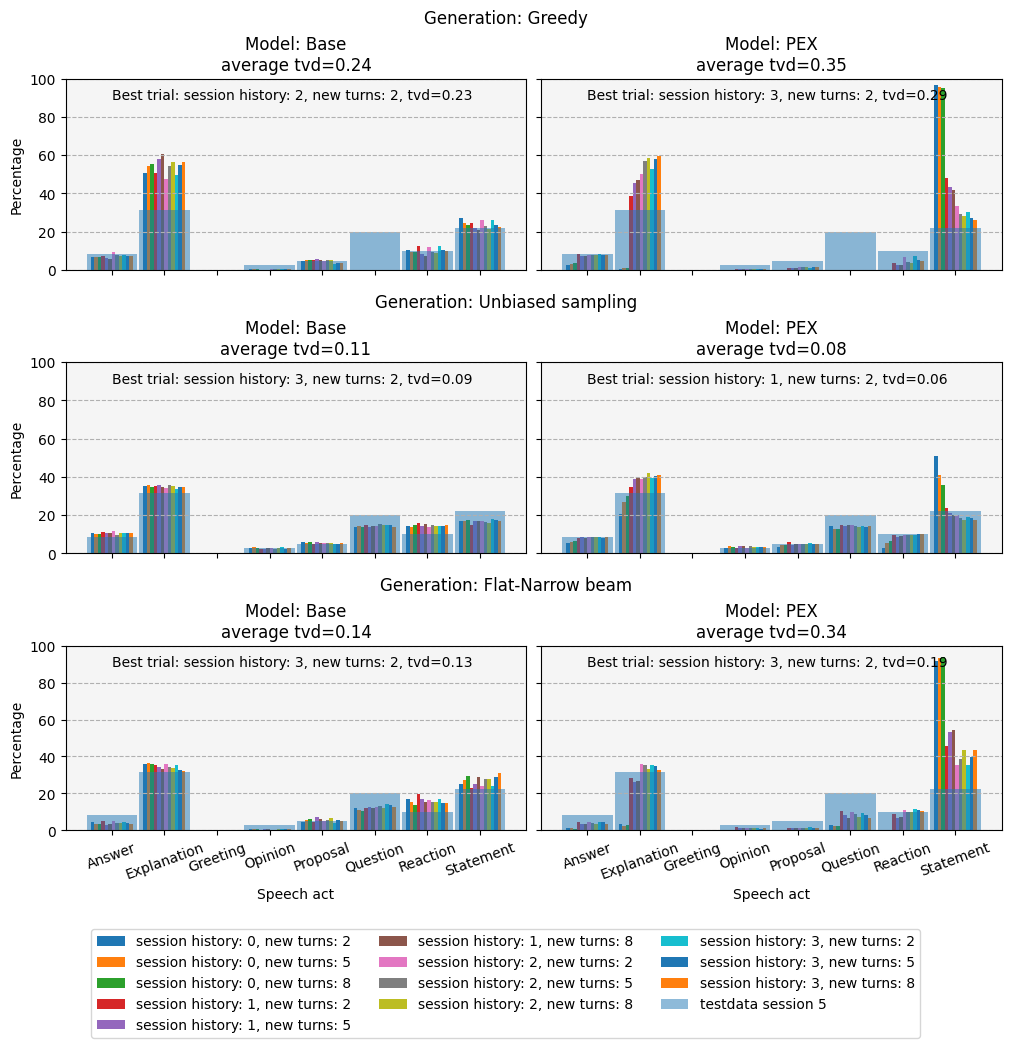

In [12]:
### ***THESIS*** Figure 5.7

# Show distribution of speechacts per model and generation config

# Choose session to visualize and baseline
session = 5
load_other = ""     # "" means both agents use the same model
baseline_subset = 'test'
baseline_session = 5        # Chart in initial thesis has baseline_session = 4, but should be 5
speechact_baseline = msc_measurements[baseline_session][baseline_subset]['speechacts']

model_list = ['trained_hib_hpc_s4_dgpt', 'trained_fb_hpc_s4_nll05bart_dgpt']

all_acts = list(MSC_SpeechAct.classes.keys())
x_labels = list(MSC_SpeechAct.classes.values())
x = np.arange(len(x_labels))
baseline_y = np.array([speechact_baseline.get(a, 0) for a in all_acts]) / sum(speechact_baseline.values())
gap_width = 0.2

selection = (all_stats_df['action'] == 'selfchat') \
    & (all_stats_df['session'] == session)
if VERSION == "FINAL":
    # configfile for thesis did not yet have 'load_other' parameter
    selection = selection & (all_stats_df['load_other'] == load_other)

print(len(all_stats_df[selection]))
assert len(all_stats_df[selection]) > 0, "No data"

gen_configs = all_stats_df[selection].groupby(by=gen_config_params).size().index

subfigs = plt.figure(layout='constrained', figsize=(5*len(model_list), 3*len(gen_configs))).subfigures(3,1, height_ratios=[1, 1, 1.2])

for row_config, subfig in zip(gen_configs, subfigs):

    axs = subfig.subplots(ncols=len(model_list), nrows=1, sharey=True)

    for model_name, ax in zip(model_list, axs):

        df = multicolumn_filter(all_stats_df[selection], list(gen_config_params) + ['load'], list(row_config) + [model_name]).sort_values(by=chat_config)
        ys = []
        # print(len(df))

        if len(df) > 0:
            bar_width = (1-gap_width) / len(df)

            with plt.style.context('seaborn-v0_8-paper'):
                best_tvd = (None, 1.0)
                for i, index in enumerate(df.index):
                    row = df.loc[index]
                    speechact_dict = dict(row['selfchat_speechacts'])
                    y = np.array([speechact_dict.get(a, 0) for a in all_acts])
                    label = format_chat_config(df.loc[index][chat_config].values)
                    # print(label)
                    # print(y)
                    offset = -(1-gap_width)/2 + bar_width / 2 + bar_width * i
                    ax.bar(x=x+offset, height=y, width=bar_width, label=label)
                    this_tvd = tvd(y, baseline_y)
                    if this_tvd < best_tvd[1]:
                        best_tvd = (label, this_tvd)
                    ys.append(y)

            ax.bar(x=x, height=baseline_y, width=0.96, alpha=0.5, color='tab:blue', label=f"{baseline_subset}data session {baseline_session}")
            y_avg = np.array(ys).mean(axis=0)
            # print(y_avg)
            ax.text(0, 0.95, f"Best trial: {best_tvd[0]}, tvd={best_tvd[1]:.2f}", va='top')
            ax.set_xticks(x)
            ax.set_xticklabels([])
            ax.set_ylim(0, 1)
            ax.set_yticks(np.linspace(0, 1, 6))
            ax.set_yticklabels(np.arange(0, 101, 20, dtype=int))
            ax.set_facecolor('whitesmoke')
            ax.set_title(f"Model: {format_modelname(model_name)}\naverage tvd={tvd(y_avg, baseline_y):.2f}")
            ax.grid(which='major', axis='y', linestyle='--')

    axs[0].set_ylabel("Percentage")
    if subfig == subfigs[-1]:
        for ax in axs:
            ax.set_xticklabels(x_labels, rotation=20)
            ax.set_xlabel("Speech act")
    # subfig.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
    subfig.suptitle(f"Generation: {format_gen_config(row_config)}")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
subfigs[-1].legend(by_label.values(), by_label.keys(), loc='lower center', bbox_to_anchor=(0.5, -0.42), ncols=3)

plt.savefig('../docs/selfchat-speechacts.pdf', dpi=300, format='pdf', bbox_inches='tight')

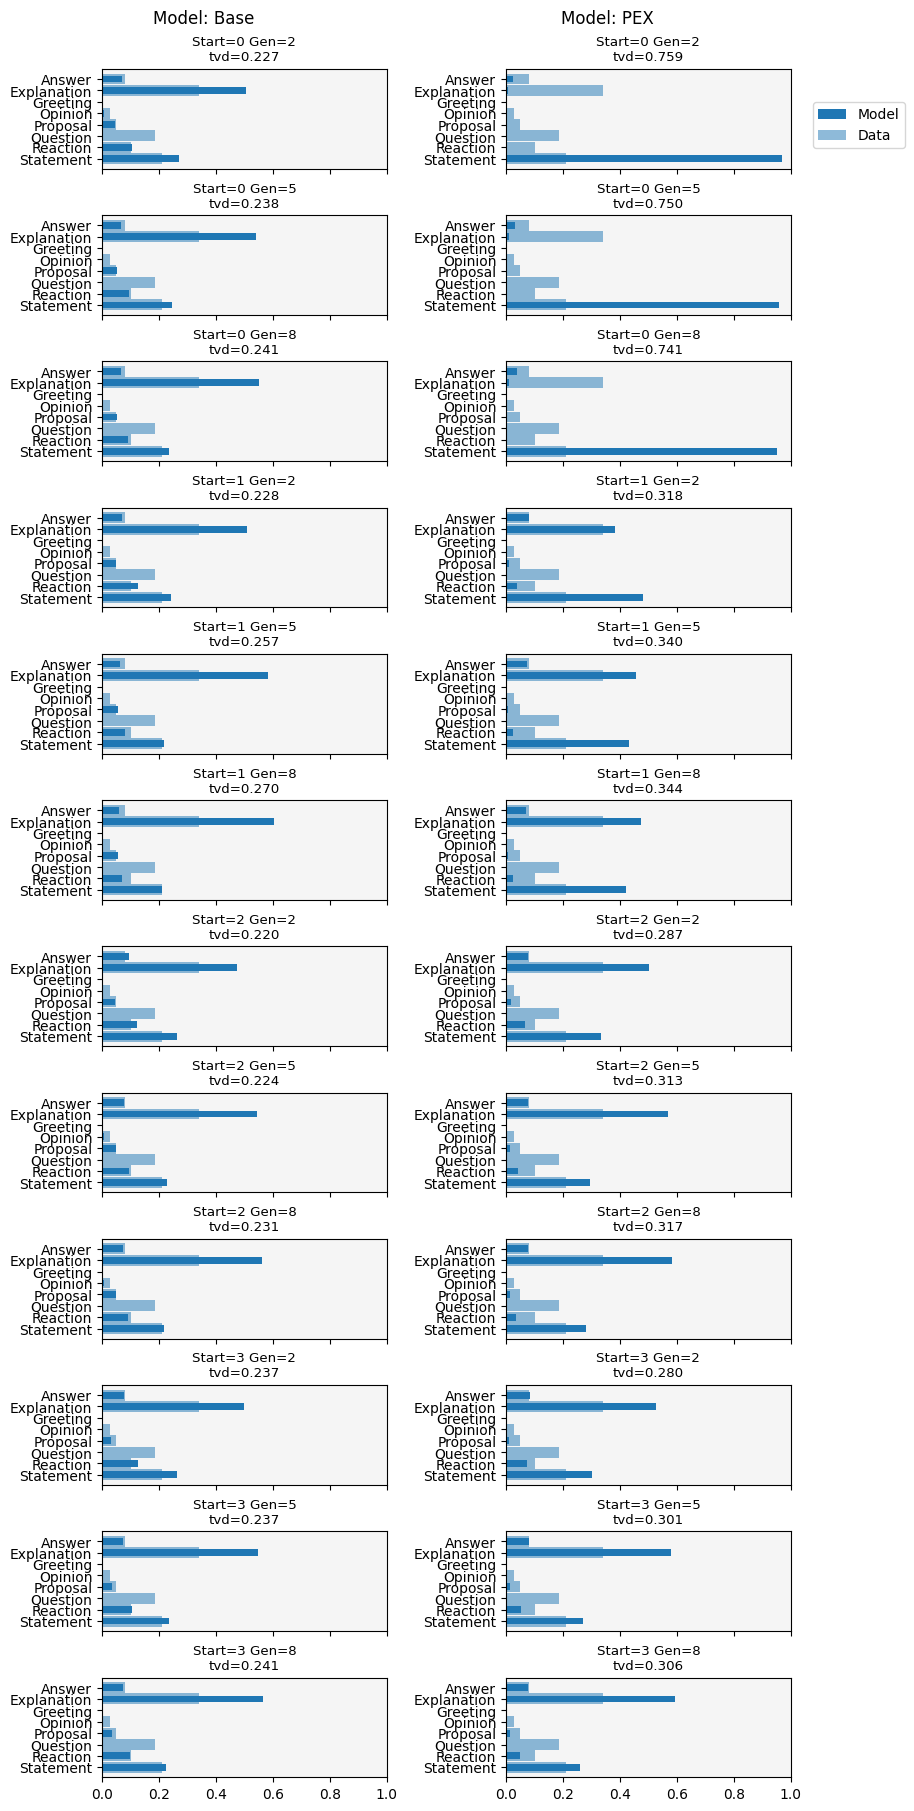

In [13]:
# Show distribution of speechacts per trial

# Choose session to visualize and baseline
session = 5
baseline_subset = 'test'
baseline_session = 4
speechact_baseline = msc_measurements[baseline_session][baseline_subset]['speechacts']

do_sample = False # There is also a series of runs with beamsearch
model_list = ['trained_hib_hpc_s4_dgpt', 'trained_fb_hpc_s4_nll05bart_dgpt']

all_acts = list(MSC_SpeechAct.classes.keys())
y_labels = list(MSC_SpeechAct.classes.values())
y = np.arange(len(y_labels))

selection = (all_stats_df['action'] == 'selfchat') \
    & (all_stats_df['session'] == session) \
    & (all_stats_df['do_sample'] == do_sample)
if VERSION == "FINAL":
    selection = selection & (all_stats_df['load_other'] == "")

chat_configs = all_stats_df[selection][chat_config].groupby(chat_config).size().index
# print(chat_configs)
# print(all_stats_df[selection][chat_config + ['date', 'session', 'load']])

subfigs = plt.figure(layout='constrained', figsize=(4*len(model_list), 1.5*len(chat_configs))).subfigures(1, 2)

for model_name, subfig in zip(model_list, subfigs):
    
    axs = subfig.subplots(nrows=len(chat_configs), ncols=1, sharex=True)

    subselection = (all_stats_df['load'] == model_name)
    df = all_stats_df[selection & subselection].sort_values(by=chat_config)
    # print(df['selfchat_speechacts'])

    speechact_dicts = [Counter(item) for item in df['selfchat_speechacts']]

    # print(speechact_dicts)
    # print(chat_configs)
    # print(len(chat_configs))

    with plt.style.context('seaborn-v0_8-paper'):
        for d, row_config, ax in zip(speechact_dicts, chat_configs, axs):

            baseline_x = np.array([speechact_baseline.get(a, 0) for a in all_acts]) / sum(speechact_baseline.values())
            ax.barh(y, width=baseline_x, height=0.96, color='tab:blue', alpha=0.5, label="Data")

            x = np.array([d.get(pattern, 0) for pattern in all_acts])
            title = f"Start={row_config[0][1]} Gen={int(row_config[1])}"
            # print(y_labels)
            # print(x)
            ax.barh(y, width=x, height=0.6, color='tab:blue', label="Model")

            ax.set_facecolor('whitesmoke')
            ax.set_title(f"{title}\ntvd={tvd(x, baseline_x):.3f}")
            ax.set_yticks(y)
            ax.set_yticklabels(y_labels)
            ax.invert_yaxis()
            ax.set_xlim(0, 1.0)

    # axs[0].set_ylabel("Speech act")
            
    subfig.suptitle(f"Model: {format_modelname(model_name)}")
    if subfig == subfigs[-1]:
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        subfig.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1, 0.95), reverse=True)


### Speechpatterns

In [14]:
sorted_by_value = lambda d: [k for k, v in sorted(d.items(), key=lambda x: x[1], reverse=True)]
sorted_by_keylen = lambda d: sorted(d.keys(), key=lambda x: (len(x), x))

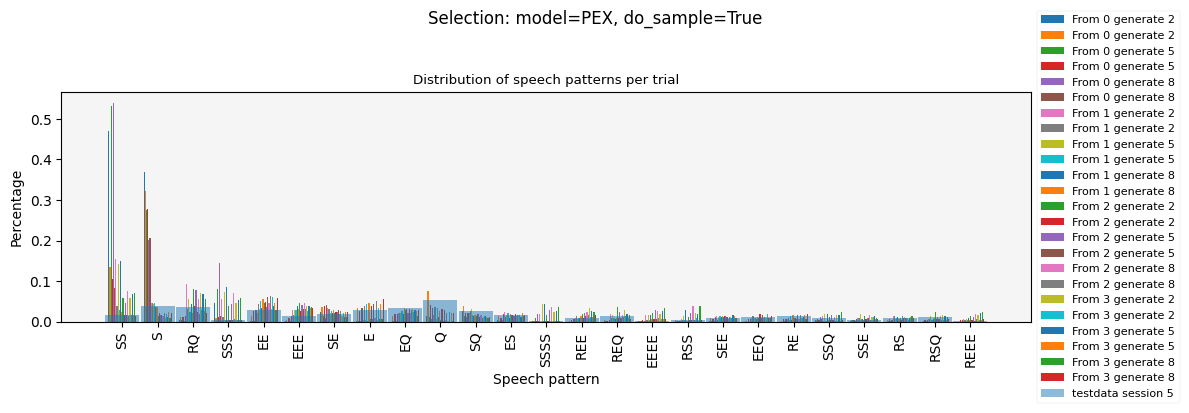

In [15]:
# Show distribution of speechpatterns per trial

# Choose session to visualize and baseline
baseline_subset = 'test'
baseline_session = 5
speechpattern_baseline = msc_measurements[baseline_session][baseline_subset]['speechpatterns']
patterns_by_value = [k for k, v in sorted(speechpattern_baseline.items(), key=lambda x: x[1], reverse=True)]
patterns_by_keylen = sorted(speechpattern_baseline.keys(), key=lambda x: (len(x), x))

# Choose model and other selection filters
model_name = 'trained_fb_hpc_s4_nll05bart_dgpt'
# model_name = 'trained_hib_hpc_s4_dgpt'
do_sample = True
selection = (all_stats_df['action'] == 'selfchat') \
    & (all_stats_df['load'] == model_name) \
    & (all_stats_df['do_sample'] == do_sample)# & (all_stats_df['num_turns'] == 8) 
if VERSION == "FINAL":
    selection = selection & (all_stats_df['load_other'] == "")
df = all_stats_df[selection].sort_values(by=chat_config)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

gap_width = 0.2
bar_width = (1-gap_width) / len(df)
max_patterns = 25

speechpattern_dicts = [Counter(item) for item in df['selfchat_speechpatterns']]
generated_patterns = set().union(*[d.keys() for d in speechpattern_dicts])
avg_pattern_distribution = {p: sum([d[p] for d in speechpattern_dicts])/len(speechpattern_dicts) for p in generated_patterns}

x_labels = sorted_by_value(avg_pattern_distribution)[:max_patterns]
x = np.arange(len(x_labels))

with plt.style.context('seaborn-v0_8-paper'):
    for i, index in enumerate(df.index):
        row = df.loc[index]
        speechpattern_dict = dict(row['selfchat_speechpatterns'])
        y = np.array([speechpattern_dict.get(pattern, 0) for pattern in x_labels])
        row_config = df.loc[index][chat_config].values
        label = f"From {row_config[0][1]} generate {int(row_config[1])}"
        # print(label)
        # print(y)
        offset = -(1-gap_width)/2 + bar_width / 2 + bar_width * i
        ax.bar(x=x+offset, height=y, width=bar_width, label=label)

    baseline_y = np.array([speechpattern_baseline.get(pattern, 0) for pattern in x_labels]) / sum(speechpattern_baseline.values())
    ax.bar(x=x, height=baseline_y, width=0.96, color='tab:blue', alpha=0.5, label=f"{baseline_subset}data session {baseline_session}")

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=90)

    ax.set_facecolor('whitesmoke')
    ax.set_title("Distribution of speech patterns per trial")
    ax.set_ylabel("Percentage")
    ax.set_xlabel("Speech pattern")

fig.suptitle(f"Selection: model={format_modelname(model_name)}, do_sample={do_sample}")   
fig.tight_layout()

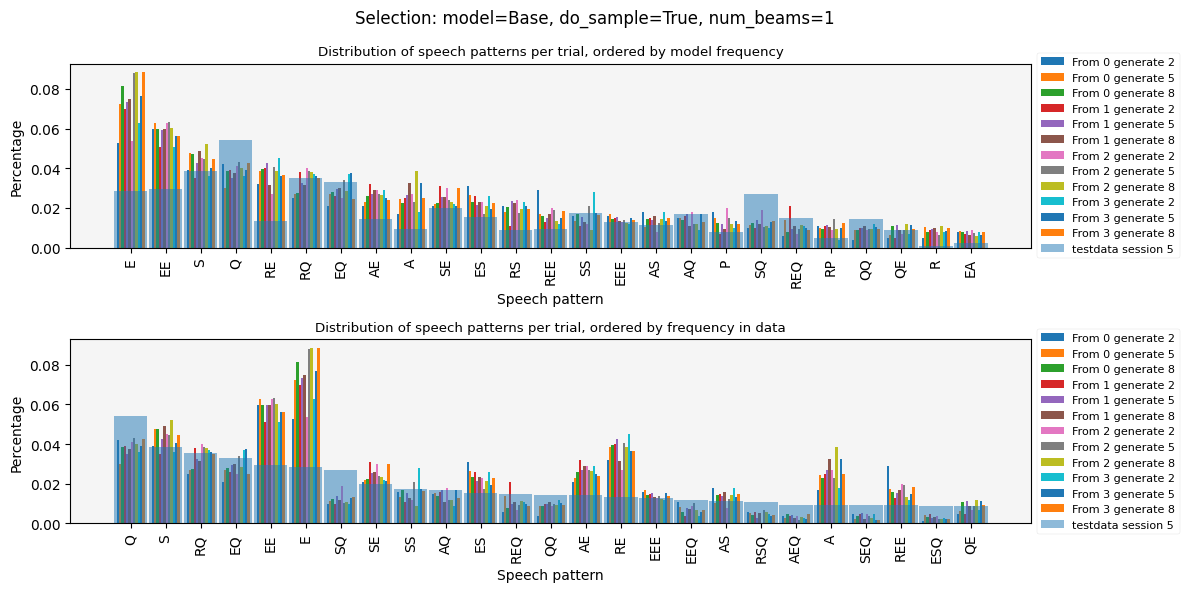

In [16]:
# Show distribution of speechpatterns per trial

# Choose baseline
baseline_subset = 'test'
baseline_session = 5
speechpattern_baseline = msc_measurements[baseline_session][baseline_subset]['speechpatterns']
patterns_by_value = [k for k, v in sorted(speechpattern_baseline.items(), key=lambda x: x[1], reverse=True)]
patterns_by_keylen = sorted(speechpattern_baseline.keys(), key=lambda x: (len(x), x))

# Choose model and other selection filters
# model = 'trained_fb_hpc_s4_nll05bart_dgpt'
model_name = 'trained_hib_hpc_s4_dgpt'
do_sample = True
num_beams = 1
selection = (all_stats_df['action'] == 'selfchat') \
    & (all_stats_df['load'] == model_name) \
    & (all_stats_df['do_sample'] == do_sample) \
    & (all_stats_df['num_beams'] == num_beams)
if VERSION == "FINAL":
    selection = selection & (all_stats_df['load_other'] == "")
df = all_stats_df[selection].sort_values(by=chat_config)

gap_width = 0.2
bar_width = (1-gap_width) / len(df)
max_patterns = 25

speechpattern_dicts = [Counter(item) for item in df['selfchat_speechpatterns']]
generated_patterns = set().union(*[d.keys() for d in speechpattern_dicts])
avg_pattern_distribution = {p: sum([d[p] for d in speechpattern_dicts])/len(speechpattern_dicts) for p in generated_patterns}

x_label_list = [
    sorted_by_value(avg_pattern_distribution)[:max_patterns],
    patterns_by_value[:max_patterns]
    # patterns_by_keylen[:max_patterns]
]
x = np.arange(len(x_labels))
titles = ["Distribution of speech patterns per trial, ordered by model frequency", "Distribution of speech patterns per trial, ordered by frequency in data"]

fig, axs = plt.subplots(ncols=1, nrows=len(x_label_list), figsize=(12, 3*len(x_label_list)))

for x_labels, title, ax in zip(x_label_list, titles, axs):

    with plt.style.context('seaborn-v0_8-paper'):
        for i, index in enumerate(df.index):
            row = df.loc[index]
            speechpattern_dict = dict(row['selfchat_speechpatterns'])
            y = np.array([speechpattern_dict.get(pattern, 0) for pattern in x_labels])
            row_config = df.loc[index][chat_config].values
            label = f"From {row_config[0][1]} generate {int(row_config[1])}"
            # print(label)
            # print(y)
            offset = -(1-gap_width)/2 + bar_width / 2 + bar_width * i
            ax.bar(x=x+offset, height=y, width=bar_width, label=label)

        baseline_y = np.array([speechpattern_baseline.get(pattern, 0) for pattern in x_labels]) / sum(speechpattern_baseline.values())
        ax.bar(x=x, height=baseline_y, width=0.96, color='tab:blue', alpha=0.5, label=f"{baseline_subset}data session {baseline_session}")

        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=90)

        ax.set_facecolor('whitesmoke')
        ax.set_title(title)
        ax.set_ylabel("Percentage")
        ax.set_xlabel("Speech pattern")

fig.suptitle(f"Selection: model={format_modelname(model_name)}, do_sample={do_sample}, num_beams={num_beams}")    
fig.tight_layout()

In [17]:
# Function to plot relative proportion of speechpatterns, ordered by length of speech pattern and frequency of occurrance

def plot_areas(ax, boxes, title):
    with plt.style.context('seaborn-v0_8-paper'):
        box_width = {
            len_p: sum([sum(boxes[len_p][pattern].values()) for pattern in boxes[len_p].keys()])
            for len_p in boxes.keys()
        }
        box_height = {
            len_p: {pattern: sum(boxes[len_p][pattern].values()) / box_width[len_p] for pattern in sorted(boxes[len_p].keys())}
            for len_p in boxes.keys()
        }

        width = [w for len_p, w in sorted(box_width.items(), key=lambda x: x[0])]
        right = np.cumsum(width)
        left = np.insert(right[:-1], 0, 0)

        max_area = 0

        for i, len_p in enumerate(sorted(boxes.keys())):

            p_by_height = [pattern for pattern, value in sorted(box_height[len_p].items(), key=lambda x: x[1], reverse=True)]
            top = np.cumsum([box_height[len_p][p] for p in p_by_height])
            bottom = np.insert(top[:-1], 0, 0)

            for j, pattern in enumerate(p_by_height):

                area = box_width[len_p] * box_height[len_p][pattern]
                max_area = max(max_area, area)
                if  area > 0.001:
                    patch = ax.add_patch(Rectangle(
                        (left[i], bottom[j]), 
                        box_width[len_p], 
                        box_height[len_p][pattern],
                        edgecolor='white',
                        facecolor='lightgrey',
                        linewidth=0.5
                    ))
                if area > 0.02:
                    patch.set(facecolor='lightsteelblue', linestyle='solid')
                    text = f"{pattern} " + f"{area:.2f}"[1:] if box_width[len_p] > box_height[len_p][pattern] else f"{pattern}\n" + f"{area:.2f}"[1:]
                    ax.text(left[i] + box_width[len_p] / 2, bottom[j] + box_height[len_p][pattern] / 2, text, ha='center', va='center')
                if area > 0.05:
                    patch.set(facecolor='yellowgreen')            

            ax.set_facecolor('whitesmoke')

        xticks = [l for l, r in zip(left, right) if (r-l > 0.02) and (1-l > 0.02)] + [1.0]
        ax.set_xticks(xticks)
        ax.set_xticklabels(["0"] + [f"{x:.2f}" for x in xticks[1:-1]] + ["1"])
        ax.set_yticks([])
        ax.set_yticklabels([])

        ax.set_title(title)
        ax.set_ylabel("Speech patterns sorted by frequency")
        ax.set_xlabel("Speech patterns sorted by length")

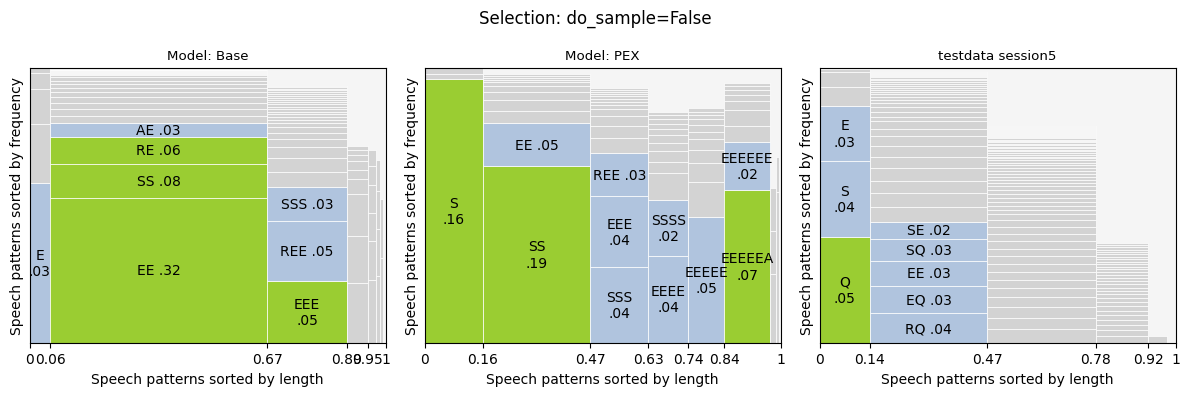

In [18]:
# Show distribution of speechpatterns per trial

# Choose baseline
baseline_subset = 'test'
baseline_session = 5
speechpattern_baseline = msc_measurements[baseline_session][baseline_subset]['speechpatterns']

model_list = ['trained_hib_hpc_s4_dgpt', 'trained_fb_hpc_s4_nll05bart_dgpt', 'Data']
do_sample = False

fig, axs = plt.subplots(ncols=len(model_list), nrows=1, figsize=(4 * len(model_list),4), sharey=True)

for model_name, ax in zip(model_list, axs):

    if model_name != 'Data':
        selection = (all_stats_df['action'] == 'selfchat') \
            & (all_stats_df['load'] == model_name) \
            & (all_stats_df['do_sample'] == do_sample)
        if VERSION == "FINAL":
            selection = selection & (all_stats_df['load_other'] == "")
        df = all_stats_df[selection].sort_values(by=chat_config)
        len_df = len(df)

        # list of normalized values, divided by number of dicts, so total adds up to 1
        speechpattern_dicts = [
            {k: v / len_df for k,v in Counter(item).items()} 
            for item in df['selfchat_speechpatterns']
        ]
    else:
        sum_count_speechpattern = sum(speechpattern_baseline.values())
        speechpattern_dicts = [{k: v / sum_count_speechpattern for k, v in speechpattern_baseline.items()}]

    generated_patterns = set().union(*[d.keys() for d in speechpattern_dicts])
    longest_length = max([len(p) for p in generated_patterns])

    boxes = {}
    for row_config, d in zip(df[chat_config].values, speechpattern_dicts):
        config_key = f"{row_config[0][1]}-{int(row_config[1])}"
        for pattern, value in d.items():
            len_p = len(pattern)
            if len_p not in boxes.keys():
                boxes[len_p] = {}
            if pattern not in boxes[len_p].keys():
                boxes[len_p][pattern] = {}
            boxes[len_p][pattern][config_key] = value

    plot_areas(ax, boxes, f"Model: {format_modelname(model_name)}" if model_name != 'Data' else f"{baseline_subset}data session{baseline_session}")

fig.suptitle(f"Selection: do_sample={do_sample}")    
fig.tight_layout()

### Reference to personas and context

In [19]:
### ***THESIS*** Figure F.3

# Show references to personas and context

# Choose baseline
baseline_subset = 'train'
baseline_session = 4
refs_baseline = msc_measurements[baseline_session][baseline_subset]
baseline_label = f"{baseline_subset[0].upper()}{baseline_subset[1:]}data session {baseline_session}"

# Choose selection filters
# model = 'trained_fb_hpc_s4_nll05bart_dgpt'
do_sample = True

model_list = ['trained_hib_hpc_s4_dgpt', 'trained_fb_hpc_s4_nll05bart_dgpt']
metric_selection = ['selfchat_ref_self', 'selfchat_ref_other', 'selfchat_ref_context']
titles = ['Refer to persona <self> ', 'Refer to persona <other>', 'Refer to previous utterance']

if VERSION == "INITIAL":
    subfigs = plt.figure(layout='constrained', figsize=(4*len(model_list), 2*len(metric_selection))).subfigures(2, 1, hspace=0.2)

    for model_name, subfig in zip(model_list, subfigs):

        axs = subfig.subplots(
            ncols=len(metric_selection), 
            nrows=1, 
            sharex=True, sharey=True
        )

        selection = (all_stats_df['action'] == 'selfchat') \
            & (all_stats_df['load'] == model_name)  \
            & (all_stats_df['do_sample'] == do_sample)
        df = all_stats_df[selection].groupby(by=chat_config)[metric_selection].agg('mean')
        with plt.style.context('seaborn-v0_8-paper'):
            for metric, title, ax in zip(metric_selection, titles, axs):

                y = [format_chat_config(row) for row in df.index]
                ax.barh(y=y, width=df[metric], label='Model')

                baseline_y = refs_baseline[metric[9:]]
                # ax.plot([baseline_y, baseline_y], [-1, len(y)], c='tab:green')
                ax.add_patch(Rectangle(
                    (0, -1), baseline_y, len(y)+1,
                    alpha=0.5,
                    facecolor='tab:blue',
                    label=f'{baseline_subset}data session {baseline_session}'
                ))

                ax.set_facecolor('whitesmoke')
                ax.set_title(title)
                ax.invert_yaxis()
                ax.set_ylim(len(y), -1)
                ax.set_xlabel("Fraction")
                ax.set_xticks(np.arange(11) * 0.2)
                ax.set_xlim(0,1)

        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        subfig.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
        subfig.suptitle(f"Selection: model={format_modelname(model_name)}, do_sample={do_sample}", y=1.1)
    
    fig.tight_layout()
    plt.savefig('../docs/selfchat-references.pdf', dpi=300, format='pdf', bbox_inches='tight')

['selfchat_ref_self_1', 'selfchat_ref_other_1', 'selfchat_ref_context_1']


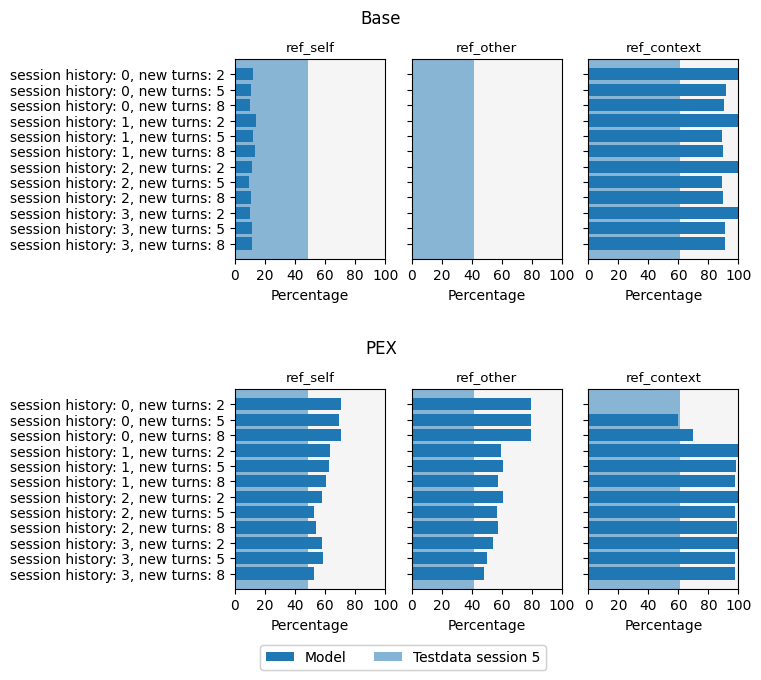

In [20]:
### ***THESIS*** Figure F.3 (update with new data)

# Show references to personas and context

# Choose baseline
baseline_subset = 'test'
baseline_session = 5
refs_baseline = msc_measurements[baseline_session][baseline_subset]
baseline_label = f"{baseline_subset[0].upper()}{baseline_subset[1:]}data session {baseline_session}"

# Choose selection filters
# model = 'trained_fb_hpc_s4_nll05bart_dgpt'
gen_config = 'Flat-Narrow beam'

model_list = ['trained_hib_hpc_s4_dgpt', 'trained_fb_hpc_s4_nll05bart_dgpt']
metric_selection = [c for c in all_stats_df.columns if (c[:13] == 'selfchat_ref_' and c[-1] == '1')]
titles = [m[9:-2] for m in metric_selection]
print(metric_selection)

if VERSION == "FINAL":
    subfigs = plt.figure(layout='constrained', figsize=(2.5*len(metric_selection), 3*len(model_list))).subfigures(2, 1, hspace=0.2)

    for model_name, subfig in zip(model_list, subfigs):

        axs = subfig.subplots(
            ncols=len(metric_selection), 
            nrows=1, 
            sharex=True, sharey=True
        )

        selection = (all_stats_df['action'] == 'selfchat') \
            & (all_stats_df['load'] == model_name)  \
            & (all_stats_df['gen_config'] == gen_config) \
            & (all_stats_df['load_other'] == "")
        df = all_stats_df[selection].groupby(by=chat_config)[metric_selection].agg('mean')
        # print(df)
        # print(all_stats_df[selection][gen_config_params])
        with plt.style.context('seaborn-v0_8-paper'):
            for metric, title, ax in zip(metric_selection, titles, axs):

                y = [format_chat_config(row) for row in df.index]
                ax.barh(y=y, width=df[metric], label='Model')

                baseline_y = refs_baseline[metric[9:-2]]
                # ax.plot([baseline_y, baseline_y], [-1, len(y)], c='tab:green')
                ax.add_patch(Rectangle(
                    (0, -1), baseline_y, len(y)+1,
                    alpha=0.5,
                    facecolor='tab:blue',
                    label=baseline_label
                ))

                ax.set_facecolor('whitesmoke')
                ax.set_title(title)
                ax.invert_yaxis()
                ax.set_ylim(len(y), -1)
                ax.set_xlabel("Percentage")
                ax.set_xticks(np.linspace(0, 1, 6))
                ax.set_xticklabels(np.arange(0, 101, 20))
                ax.set_xlim(0,1)

        # subfig.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
        
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        subfigs[-1].legend(by_label.values(), by_label.keys(), loc='lower center', ncols=2, bbox_to_anchor=(0.53, -0.15), reverse=True)

        # subfig.suptitle(f"Selection: model={format_modelname(model_name)}, gen_config={gen_config}", y=1.1)
        subfig.suptitle(f"{format_modelname(model_name)}", y=1.1)
    fig.tight_layout()
    plt.savefig('../docs/selfchat-references.pdf', dpi=300, format='pdf', bbox_inches='tight')

### Inspect individual selfchats

In [21]:
# Convert eval_results to DataFrame and combine with config

chat_df = pd.concat([
    pd.DataFrame.from_records(
        list(chatresults_dict[trial_name].values()),
        index=pd.MultiIndex.from_tuples(list(chatresults_dict[trial_name].keys()))
    )
    for trial_name in chatresults_dict.keys()
])
chat_df = chat_df.join(all_config_df, on='trial_name')
chat_df['gen_config'] = chat_df[gen_config_params].apply(format_gen_config, axis=1).astype(gen_config_cat)
# chat_df['model_name'] = chat_df['load'].apply(format_modelname, axis=1)
if VERSION == "FINAL":
    chat_df['gen_config_other'] = chat_df[[f"{c}_other" for c in gen_config_params]].apply(format_gen_config, axis=1).astype(gen_config_cat)
chat_df = chat_df.droplevel(0)
chat_df.reset_index(inplace=True, names=['dialog_id', 'turn_id'])
print("Number of selfchats in dataframe: ", len(chat_df))
chat_df.head()

Number of selfchats in dataframe:  50100


,dialog_id,turn_id,speechacts,speechpatterns,p(A|Q),ref_self_1,ref_self_2,ref_other_1,ref_other_2,ref_context_1,...,include_history,input_order,sessionbreak_token,session,augmented,selected_turns,persona_selector,speechact_classifier,gen_config,gen_config_other
0,0,0,"{'S': 1, 'R': 1, 'E': 6, 'P': 3, 'A': 1}","{'S': 1, 'RE': 1, 'EEP': 1, 'AP': 1, 'EEEP': 1}",0.0,0.333333,0.0,1.000000,1.5,0.666667,...,False,personas-history-current,<session>,5,False,[0],preprocessed:trained_nll05_bart,trained_speechact_bert,Flat-Narrow beam,Greedy
1,1,0,"{'S': 7, 'A': 3}","{'SS': 2, 'AS': 3}",0.0,1.000000,0.0,1.000000,1.5,0.666667,...,False,personas-history-current,<session>,5,False,[0],preprocessed:trained_nll05_bart,trained_speechact_bert,Flat-Narrow beam,Greedy
2,2,0,"{'S': 3, 'R': 2, 'E': 5, 'A': 1}","{'S': 1, 'RE': 1, 'ESA': 1, 'REE': 1, 'SE': 1}",0.0,0.333333,0.0,1.000000,1.5,0.666667,...,False,personas-history-current,<session>,5,False,[0],preprocessed:trained_nll05_bart,trained_speechact_bert,Flat-Narrow beam,Greedy
3,3,0,"{'S': 1, 'E': 16}","{'SE': 1, 'EEEEE': 1, 'EEE': 2, 'EEEE': 1}",0.0,0.000000,0.0,0.333333,0.5,0.666667,...,False,personas-history-current,<session>,5,False,[0],preprocessed:trained_nll05_bart,trained_speechact_bert,Flat-Narrow beam,Greedy
4,4,0,{'S': 7},"{'S': 3, 'SS': 2}",0.0,1.000000,1.0,1.000000,1.5,0.666667,...,False,personas-history-current,<session>,5,False,[0],preprocessed:trained_nll05_bart,trained_speechact_bert,Flat-Narrow beam,Greedy


In [22]:
chat_df.columns

Index(['dialog_id', 'turn_id', 'speechacts', 'speechpatterns', 'p(A|Q)',
       'ref_self_1', 'ref_self_2', 'ref_other_1', 'ref_other_2',
       'ref_context_1', 'ref_context_2', 'selfchat', 'trial_name',
       'configfile', 'seed', 'checkpoint_dir', 'output_dir', 'log_interval',
       'loglevel', 'logdir', 'load', 'save', 'device', 'use_wandb', 'action',
       'model', 'task', 'experiment_name', 'epochs', 'learning_rate',
       'valid_interval', 'patience', 'batch_size', 'skip_eval', 'metrics',
       'print_max', 'temperature', 'top_p', 'top_k', 'do_sample', 'num_beams',
       'num_turns', 'new_agent', 'load_other', 'include_persona_other',
       'include_history_other', 'input_order_other', 'persona_selector_other',
       'temperature_other', 'top_p_other', 'top_k_other', 'do_sample_other',
       'num_beams_other', 'lm', 'decoder_max', 'datadir', 'basedir',
       'train_samples', 'valid_samples', 'test_samples', 'speaker_prefixes',
       'add_tokens', 'include_persona', 'i

In [23]:
# Helper functions to print the selfchats from the chatresults file.

def cleanup_mem_list(mem_lines):
    cleaned = []
    for line in mem_lines[1:]:
        line_split = line.split(':', 1)
        if len(line_split) > 1:
            cleaned.append(line_split[1][1:])
    return cleaned

def get_agent_components(agent_lines):
    mem_start = []
    dialog_start = []
    for i, line in enumerate(agent_lines):
        if line[:10] == 'TextMemory':
            mem_start.append((i, line[11:]))
        if line[:10] == 'Dialogues:':
            dialog_start.append((i, line[11:]))
    mem_A = (mem_start[0][1], cleanup_mem_list(agent_lines[mem_start[0][0] + 1: mem_start[1][0]]))
    mem_B = (mem_start[1][1], cleanup_mem_list(agent_lines[mem_start[1][0] + 1: dialog_start[0][0]]))
    dialog = (dialog_start[0][1], agent_lines[dialog_start[0][0] + 1: ])
    return agent_lines[0], mem_A, mem_B, dialog

def get_selfchat_components(selfchat_string):
    lines = selfchat_string.split('\n')
    # print(len(lines))
    idx1 = lines.index('----------')
    idx2 = lines[idx1 + 1:].index('----------')
    generated_dialogue = lines[idx1 + 1 + idx2 + 2:-2]
    agent_A = lines[:idx1-len(generated_dialogue)]
    agent_B = lines[idx1 + 1 : idx1 + 1 + idx2 - len(generated_dialogue)]
    return get_agent_components(agent_A), get_agent_components(agent_B), generated_dialogue

In [24]:
### ***THESIS*** Table 5.5 (added after handin)

# Choose a dialogue from the test dataset to use as basis for the selfchat, and define the filter
dialog_id = 1
if VERSION == "FINAL":
    selection = (chat_df['dialog_id'] == dialog_id) \
        & (chat_df['gen_config'] == 'Flat-Narrow beam')& (chat_df['load_other'] == '') & (chat_df['load'] == 'trained_fb_hpc_s4_nll05bart_dgpt')
        # & (chat_df['gen_config'] == 'Flat-Narrow beam')& (chat_df['load_other'] == '') & (chat_df['load'] == 'trained_hib_hpc_s4_dgpt')

    # Print the personas in the agent memory, the dialogue history and the generated utterances for the selected trial
    # Ajust output so it can be easily pasted into latex.
    agent_A, agent_B, gen_dialogue = get_selfchat_components(chat_df[selection].sort_values(by=['turn_id', 'num_turns']).iloc[7]['selfchat'])
    print(f"=== {agent_A[0]} ===")
    print(f"=== {agent_A[1][0]} ===\n" + ' \\\\\n'.join(agent_A[1][1]))
    print(f"=== {agent_A[2][0]} ===\n" + ' \\\\\n'.join(agent_A[2][1]))
    print("=== History ===\n" + ' \\\\\n'.join([u.replace('\t', ' ') for u in agent_A[3][1]]))
    print("=== Generated ===\n" + ' \\\\\n'.join([u.replace('\t', ' ') for u in gen_dialogue]))
else:
    selection = (chat_df['dialog_id'] == dialog_id) \
        & (chat_df['gen_config'] == 'Flat-Narrow beam') & (chat_df['load'] == 'trained_fb_hpc_s4_nll05bart_dgpt')

    for s in chat_df[selection]['selfchat']:
        print(s)

=== AGENT Speaker 1 ===
=== Speaker 1 ===
I am girl. \\
I am a young girl who is still in highschool. \\
I enjoy marching band in the fall and concert band in the season. \\
My parents are both teachers. \\
My favorite subject is english. \\
I play a band in school. \\
I play football for my high school. \\
I play the trumpet. \\
I live in Oklahoma City. \\
I am busy. I have a school band. \\
I work on music and academics. \\
I am nervous to go to a concert. \\
I am always nervous in crowds. \\
I need someone to go with me to a concert. \\
I am shy. I have magic sword shirts. \\
I am going to a concert. \\
I don't like big egg companies. \\
I have tickets for a Magic Sword concert next month. \\
I am nervous.
=== Speaker 2 ===
I drive 1,000 miles a day. I have a fave band. \\
I have 2 older brothers. I like Roxy music. \\
I am from meself. \\
I just moved to Charlotte, NC. \\
I went to a concert. \\
I have a brother. \\
I want to pursue music. I am in high school. \\
I am a farmer. I l